## 

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import kala
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from typing import Sequence

In [1]:
def helper_diagonal_sbm(num_nodes, p_off, p_diag=1.0, seed=0, return_pos=True):
    n = num_nodes // 2
    sizes = [n, n + num_nodes % 2]

    p_mat = [
        [p_diag, p_off],
        [p_off, p_diag],
    ]

    g = nx.stochastic_block_model(sizes, p_mat, seed=seed)
    # g.graph["partition"]

    if return_pos:
        pos = nx.spring_layout(g, seed=seed)
        out = (g, pos)
    else:
        out = g

    return out


def helper_two_group_assigment(num_nodes, threshold=0.5, seed=0):
    rng = np.random.default_rng(seed)

    n = num_nodes // 2
    if isinstance(threshold, float):
        block1 = rng.random(size=n) < threshold
        block2 = rng.random(size=n + num_nodes % 2) < 1 - threshold
    elif isinstance(threshold, Sequence) and len(threshold) == 2:
        block1 = rng.random(size=n) < threshold[0]
        block2 = rng.random(size=n + num_nodes % 2) < threshold[1]
    else:
        raise TypeError("treshold must be a float or a sequence of two floats")

    return np.hstack((block1, block2))


def _get_broken_down_wealth(game, is_saver):
    return (
        game.get_total_wealth(),
        game.get_total_wealth(filt=is_saver),
        game.get_total_wealth(filt=~is_saver),
    )


def helper_run_simulation(game, is_saver, num_steps):
    game.reset_agents()

    data = [_get_broken_down_wealth(game, is_saver)]

    for _ in range(num_steps):
        game.play_round()
        data.append(_get_broken_down_wealth(game, is_saver))

    return pd.DataFrame(data, columns=["total", "saver", "non-saver"])

In [4]:
num_players = 40

g, pos = helper_diagonal_sbm(num_players, p_off=0.1)

kwargs = {
    "differential_efficient": 0.15,
    "differential_inefficient": 0.1,
}

deterministic_strategy = kala.CooperationStrategy(stochastic=False, **kwargs)
stochastic_strategy = kala.CooperationStrategy(stochastic=True, rng=0, **kwargs)

## Validation: all the players are non-savers

When all the players are non-savers, the wealth should increase at a constant rate of `num_players` units per time even for the case of a stochastic strategy (stochastic payoffs).

In [5]:
is_saver = np.zeros(num_players, dtype=bool)

print(f"Savers:\t\t{np.sum(is_saver)}")
print(f"Non-savers:\t{np.sum(~is_saver)}")

Savers:		0
Non-savers:	40


In [6]:
players = [kala.InvestorAgent(is_saver=s) for s in is_saver]
G = kala.SimpleGraph(g, nodes=players)

game = kala.DiscreteTwoByTwoGame(G, stochastic_strategy)

results_all_non_savers = helper_run_simulation(game, is_saver, num_steps=50)

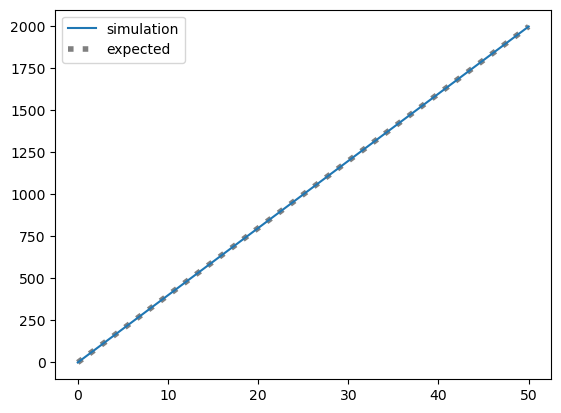

In [7]:
xs = np.array([0, 50])
ys = xs * num_players

fig, ax = plt.subplots()
results_all_non_savers["total"].plot(ax=ax, label="simulation")
ax.plot(
    xs, ys, color="0.5", linestyle="dotted", linewidth=4, zorder=-1, label="expected"
)
ax.legend()

## Homogenous mixing

If there is the same rate of savers in both clusters, then savers and non-savers alike are connected in the same way and we are in the case of homogeneous mixing.

100%|██████████| 500/500 [01:00<00:00,  8.25it/s]


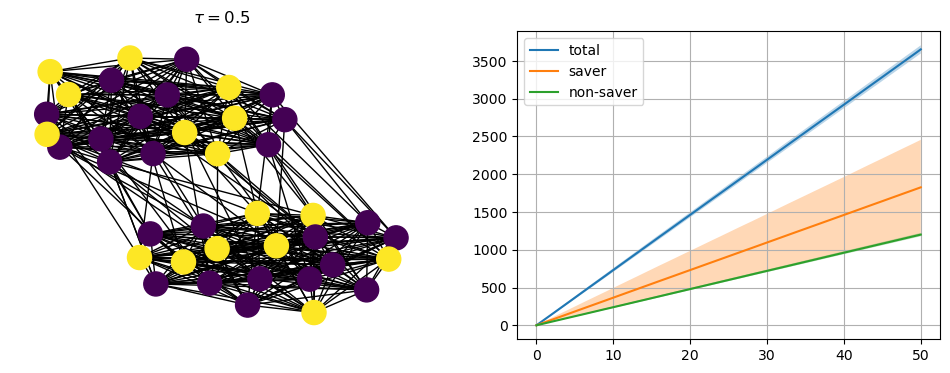

In [153]:
saver_thresh = 0.5
num_simulations = 500
num_steps = 50

results_05 = pd.DataFrame(index=np.arange(num_steps))
for simulation in tqdm(range(num_simulations)):
    is_saver = helper_two_group_assigment(num_players, threshold=saver_thresh)

    players = [kala.InvestorAgent(is_saver=s) for s in is_saver]
    G = kala.SimpleGraph(g, nodes=players)

    game = kala.DiscreteTwoByTwoGame(G, stochastic_strategy)

    results = helper_run_simulation(game, is_saver, num_steps=num_steps)
    results_05 = results.join(results_05, rsuffix=f"_{simulation}")

results_05_mean, results_05_std = get_mean_and_std_from(results_05)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

ax = axs[0]
nx.draw(g, node_color=is_saver, pos=pos, ax=ax)
ax.set_title(rf"$\tau = {saver_thresh}$")

ax = axs[1]
results_05_mean.plot(ax=ax);
plot_std(results_05_mean, results_05_std, alpha=0.3)
plt.grid()

## Inhomogeneuous mixing

Each cluster has savers/non-savers at a higher rate so that the mixing between different types of agents is poor.

100%|██████████| 500/500 [01:01<00:00,  8.12it/s]


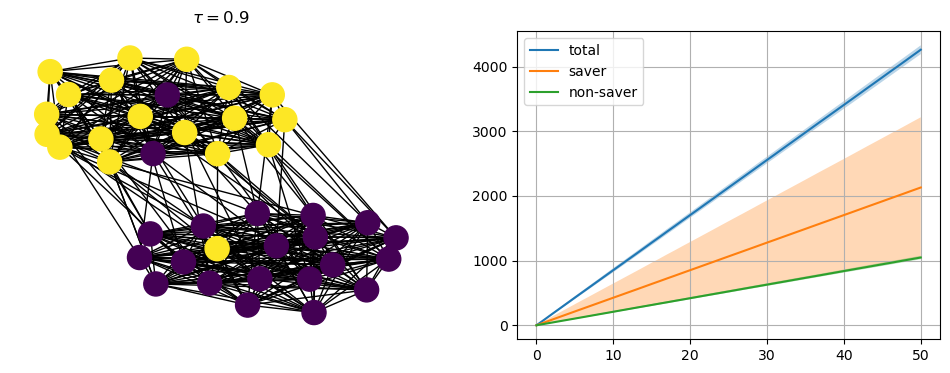

In [154]:
saver_thresh = 0.9
num_simulations = 500
num_steps = 50

results_09 = pd.DataFrame(index=np.arange(num_steps))
for simulation in tqdm(range(num_simulations)):
    is_saver = helper_two_group_assigment(num_players, threshold=saver_thresh)

    players = [kala.InvestorAgent(is_saver=s) for s in is_saver]
    G = kala.SimpleGraph(g, nodes=players)

    game = kala.DiscreteTwoByTwoGame(G, stochastic_strategy)

    results = helper_run_simulation(game, is_saver, num_steps=num_steps)
    results_09 = results.join(results_09, rsuffix=f"_{simulation}")

results_09_mean, results_09_std = get_mean_and_std_from(results_09)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

ax = axs[0]
nx.draw(g, node_color=is_saver, pos=pos, ax=ax)
ax.set_title(rf"$\tau = {saver_thresh}$")

ax = axs[1]
results_09_mean.plot(ax=ax);
plot_std(results_09_mean, results_09_std, alpha=0.3)
plt.grid()

## Side-by-side comparison

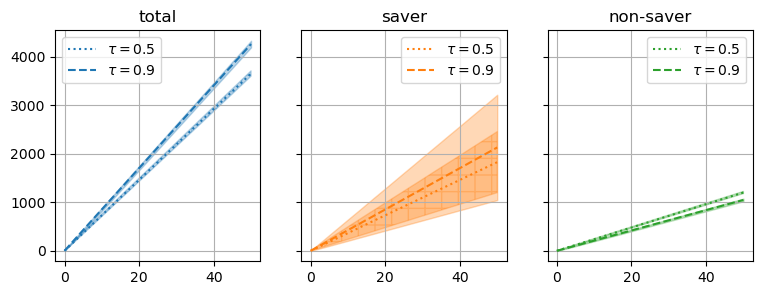

In [155]:
fig, axs = plt.subplots(figsize=(9, 3), ncols=3, sharey=True)

for ax, col, c in zip(axs, ["total", "saver", "non-saver"], ["C0", "C1", "C2"]):
    results_05_mean[col].plot(color=c, linestyle="dotted", ax=ax, label=r"$\tau = 0.5$")
    results_09_mean[col].plot(color=c, linestyle="dashed", ax=ax, label=r"$\tau = 0.9$")

    ax.fill_between(np.arange(num_steps+1),
        results_05_mean[col]-results_05_std[col],
        results_05_mean[col]+results_05_std[col],
        alpha=0.3, color=c, hatch="+")
    ax.fill_between(np.arange(num_steps+1),
        results_09_mean[col]-results_09_std[col],
        results_09_mean[col]+results_09_std[col],
        alpha=0.3, color=c)
    ax.set_title(col)
    ax.legend()
    ax.grid()


## Benchmarking

In [ ]:
def get_mean_and_std_from(results, cols=["saver", "non-saver"]):
    results_mean = results[
        [col for col in results.columns if "total" in col]
    ].mean(axis=1).to_frame("total")
    results_mean[cols[0]] = results[
        [col for col in results.columns if "saver" in col]
    ].mean(axis=1)
    results_mean[cols[1]] = results[
        [col for col in results.columns if "non-saver" in col]
    ].mean(axis=1)

    results_std = results[
        [col for col in results.columns if "total" in col]
    ].std(axis=1).to_frame("total")
    results_std[cols[0]] = results[
        [col for col in results.columns if "saver" in col]
    ].std(axis=1)
    results_std[cols[1]] = results[
        [col for col in results.columns if "non-saver" in col]
    ].std(axis=1)

    return results_mean, results_std

def plot_std(results_mean, results_std, alpha):
    for col in results_mean.columns:
        plt.fill_between(
            np.arange(len(results_mean)),
            results_mean[col]-results_std[col],
            results_mean[col]+results_std[col],
            alpha=alpha,
            )
    

100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


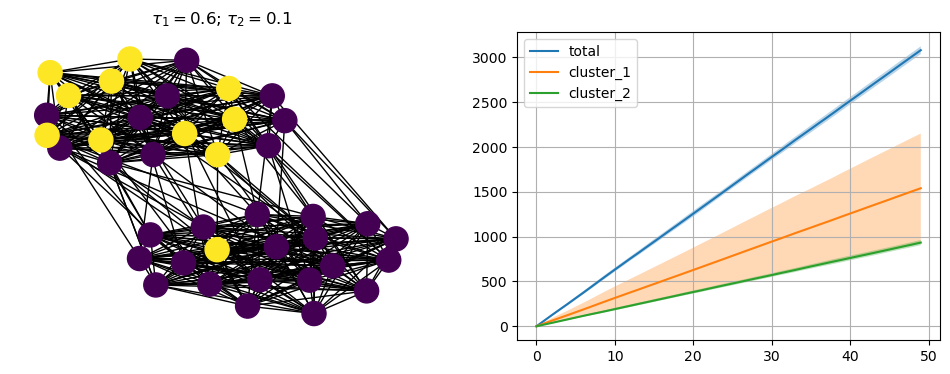

In [156]:
clusters_thresh = [0.6, 0.1]
num_simulations = 100
num_steps = 50
clusters = np.zeros(num_players, dtype=bool)
clusters[:num_nodes//2] = True
cols = ["cluster_1", "cluster_2"]

results = pd.DataFrame(index=np.arange(50))
for simulation in tqdm(range(num_simulations)):
    is_saver = helper_two_group_assigment(num_players, threshold=clusters_thresh)

    players = [kala.InvestorAgent(is_saver=s) for s in is_saver]
    G = kala.SimpleGraph(g, nodes=players)

    game = kala.DiscreteTwoByTwoGame(G, stochastic_strategy)

    results_cluster = helper_run_simulation(game, clusters, num_steps=num_steps)
    results = results.join(results_cluster, rsuffix=f"_{simulation}")

results_mean_c1, results_std_c1 = get_mean_and_std_from(results, cols=cols)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

ax = axs[0]
nx.draw(g, node_color=is_saver, pos=pos, ax=ax)
ax.set_title(rf"$\tau_1 = {clusters_thresh[0]}$; $\tau_2 = {clusters_thresh[1]}$")

ax = axs[1]
results_mean_c1.plot(ax=ax);
plot_std(results_mean_c1, results_std_c1, alpha=0.3)
plt.grid()

100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


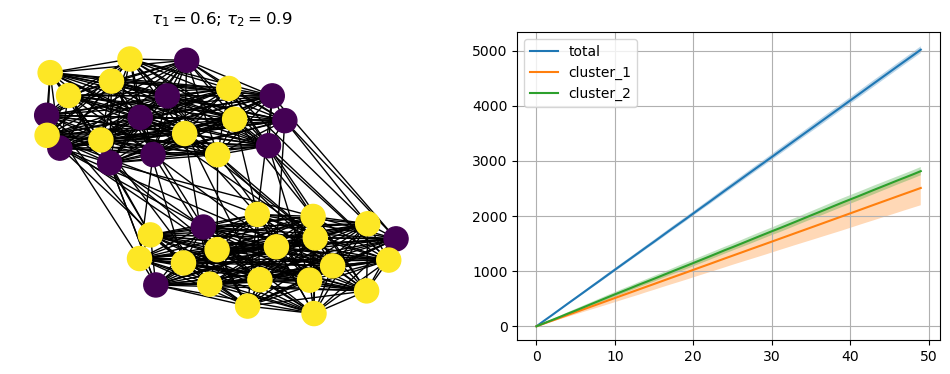

In [157]:
clusters_thresh = [0.6, 0.9]
num_simulations = 100
num_steps = 50
clusters = np.zeros(num_players, dtype=bool)
clusters[:num_nodes//2] = True
cols = ["cluster_1", "cluster_2"]

results = pd.DataFrame(index=np.arange(50))
for simulation in tqdm(range(num_simulations)):
    is_saver = helper_two_group_assigment(num_players, threshold=clusters_thresh)

    players = [kala.InvestorAgent(is_saver=s) for s in is_saver]
    G = kala.SimpleGraph(g, nodes=players)

    game = kala.DiscreteTwoByTwoGame(G, stochastic_strategy)

    results_cluster = helper_run_simulation(game, clusters, num_steps=num_steps)
    results = results.join(results_cluster, rsuffix=f"_{simulation}")

results_mean_c2, results_std_c2 = get_mean_and_std_from(results, cols=cols)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

ax = axs[0]
nx.draw(g, node_color=is_saver, pos=pos, ax=ax)
ax.set_title(rf"$\tau_1 = {clusters_thresh[0]}$; $\tau_2 = {clusters_thresh[1]}$")

ax = axs[1]
results_mean_c2.plot(ax=ax);
plot_std(results_mean_c2, results_std_c2, alpha=0.3)
plt.grid()

100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


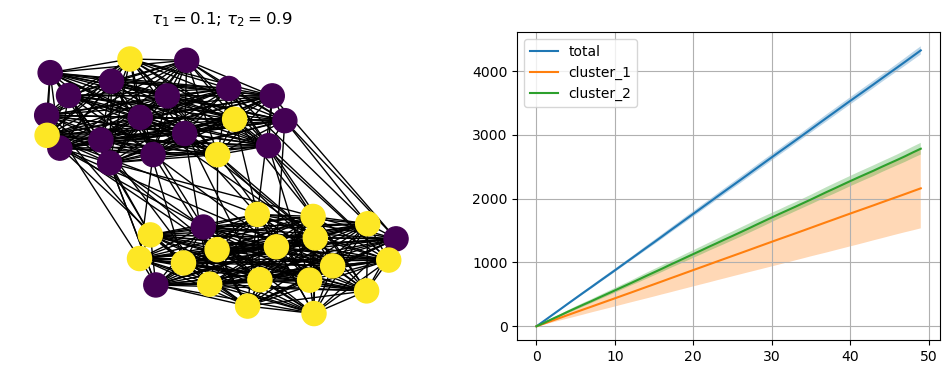

In [159]:
clusters_thresh = [0.1, 0.9]
num_simulations = 100
num_steps = 50
clusters = np.zeros(num_players, dtype=bool)
clusters[:num_nodes//2] = True
cols = ["cluster_1", "cluster_2"]

results = pd.DataFrame(index=np.arange(50))
for simulation in tqdm(range(num_simulations)):
    is_saver = helper_two_group_assigment(num_players, threshold=clusters_thresh)

    players = [kala.InvestorAgent(is_saver=s) for s in is_saver]
    G = kala.SimpleGraph(g, nodes=players)

    game = kala.DiscreteTwoByTwoGame(G, stochastic_strategy)

    results_cluster = helper_run_simulation(game, clusters, num_steps=num_steps)
    results = results.join(results_cluster, rsuffix=f"_{simulation}")

results_mean_c3, results_std_c3 = get_mean_and_std_from(results, cols=cols)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

ax = axs[0]
nx.draw(g, node_color=is_saver, pos=pos, ax=ax)
ax.set_title(rf"$\tau_1 = {clusters_thresh[0]}$; $\tau_2 = {clusters_thresh[1]}$")

ax = axs[1]
results_mean_c3.plot(ax=ax);
plot_std(results_mean_c3, results_std_c3, alpha=0.3)
plt.grid()

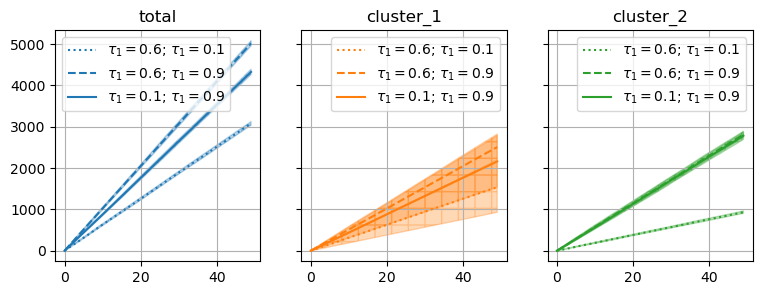

In [164]:
fig, axs = plt.subplots(figsize=(9, 3), ncols=3, sharey=True)

for ax, col, c in zip(axs, ["total", "cluster_1", "cluster_2"], ["C0", "C1", "C2"]):
    results_mean_c1[col].plot(color=c, linestyle="dotted", ax=ax, label=r"$\tau_1 = 0.6$; $\tau_1 = 0.1$")
    results_mean_c2[col].plot(color=c, linestyle="dashed", ax=ax, label=r"$\tau_1 = 0.6$; $\tau_1 = 0.9$")
    results_mean_c3[col].plot(color=c, linestyle="solid", ax=ax, label=r"$\tau_1 = 0.1$; $\tau_1 = 0.9$")

    ax.fill_between(np.arange(num_steps),
        results_mean_c1[col]-results_std_c1[col],
        results_mean_c1[col]+results_std_c1[col],
        alpha=0.3, color=c, hatch="+")
    ax.fill_between(np.arange(num_steps),
        results_mean_c2[col]-results_std_c2[col],
        results_mean_c2[col]+results_std_c2[col],
        alpha=0.3, color=c, hatch="+")
    ax.fill_between(np.arange(num_steps),
        results_mean_c3[col]-results_std_c3[col],
        results_mean_c3[col]+results_std_c3[col],
        alpha=0.3, color=c, hatch="+")
    ax.set_title(col)
    ax.legend()
    ax.grid()